# PROJET 7 : implémentez un modèle de scoring

### Connaissance des données
Les données sont fournies par Home Credit, un service dédié à l'octroi de lignes de crédit (prêts) à la population non bancarisée. Prédire si un client remboursera ou aura des difficultés à rembourser un prêt est un besoin commercial crucial, et Home Credit organise cette compétition sur Kaggle pour voir quelles sortes de modèles la communauté d'apprentissage automatique peut développer pour les aider dans cette tâche.

Il existe 7 sources différentes de données :

- **application_train/application_test** : les données principales d'entraînement et de test avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique SK_ID_CURR. Les données d'application d'entraînement sont accompagnées de la CIBLE (TARGET) indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.
- **bureau** : données concernant les crédits précédents du client auprès d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans le bureau, mais un prêt dans les données d'application peut avoir plusieurs crédits précédents.
- **bureau_balance** : données mensuelles sur les crédits précédents dans le bureau. Chaque ligne représente un mois d'un crédit précédent, et un seul crédit précédent peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
- **previous_application** : demandes de prêts précédentes chez Home Credit de clients ayant des prêts dans les données d'application. Chaque prêt actuel dans les données d'application peut avoir plusieurs prêts précédents. Chaque demande précédente a une ligne et est identifiée par la caractéristique SK_ID_PREV.
- **POS_CASH_BALANCE** : données mensuelles sur les précédents points de vente ou les prêts en espèces que les clients ont eus avec Home Credit. Chaque ligne représente un mois d'un précédent point de vente ou d'un prêt en espèces, et un seul prêt précédent peut avoir de nombreuses lignes.
- **credit_card_balance** : données mensuelles sur les anciennes cartes de crédit que les clients ont eues avec Home Credit. Chaque ligne représente un mois d'un solde de carte de crédit, et une seule carte de crédit peut avoir de nombreuses lignes.
- **installments_payment** : historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

In [1]:
import mlflow
# demarrage d'une "expérience" 
mlflow.set_experiment("Default Risk Scoring")

2023/06/07 14:40:40 INFO mlflow.tracking.fluent: Experiment with name 'Default Risk Scoring' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/danongohou/Desktop/DataScience/P7-CreditScoring/mlruns/579437955267063212', creation_time=1686141640057, experiment_id='579437955267063212', last_update_time=1686141640057, lifecycle_stage='active', name='Default Risk Scoring', tags={}>

In [2]:
mlflow.start_run(run_name='Modellisation')

<ActiveRun: >

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from dataprep import eda
import qgrid
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import joblib 
from numba import njit
from numba import generated_jit
from numba import types

from sklearn.utils import resample
from collections import Counter

%matplotlib inline 

import gc
import time
from contextlib import contextmanager
# File system manangement
import os
import os.path
from os import path 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import average_precision_score


from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification

from collections import Counter
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks

import scipy.stats as stats
from sklearn.metrics import confusion_matrix, make_scorer

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
import shap
import pickle
import joblib

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

bleu = (70 / 255, 130 / 255, 180 / 255)
pd.set_option('display.max_row', 219)
pd.set_option('display.max_column', 243)
pd.set_option('display.max_colwidth', 50)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')



# 1 - Les Données

In [4]:
application_train = pd.read_csv('./data/application_train.csv')
application_test = pd.read_csv('./data/application_test.csv')
bureau = pd.read_csv('./data/bureau.csv')
bureau_balance = pd.read_csv('./data/bureau_balance.csv')
previous_application = pd.read_csv('./data/previous_application.csv')
POS_CASH_balance = pd.read_csv('./data/POS_CASH_balance.csv')
installments_payments = pd.read_csv('./data/installments_payments.csv')
credit_card_balance = pd.read_csv('./data/credit_card_balance.csv')
HomeCredit_columns_description = pd.read_csv('./data/HomeCredit_columns_description.csv',encoding= 'unicode_escape')
                  

# 2 - Vue globale des fichiers (row, columnd, Duplicate, NaN)

In [5]:
jeu_de_donnees = [application_train,
                  application_test,
                  bureau,
                  bureau_balance,
                  previous_application,
                  POS_CASH_balance,
                  installments_payments,
                  credit_card_balance]

df_noms = ['application_train',
           'application_test',
           'bureau',
           'bureau_balance',
           'previous_application',
           'POS_CASH_balance',
           'installments_payments',
           'credit_card_balance']

vue_globale = pd.DataFrame({},)
vue_globale['Datasets'] = df_noms
vue_globale['nom de colonnes'] = [
    ', '.join([col for col in df.columns]) for df in jeu_de_donnees]
vue_globale['Nombre de lignes'] = [df.shape[0] for df in jeu_de_donnees]
vue_globale['Nombre de colonnes'] = [df.shape[1] for df in jeu_de_donnees]
vue_globale['Doublons'] = [df.duplicated().sum() for df in jeu_de_donnees]
vue_globale['NaN'] = [df.isnull().sum().sum() for df in jeu_de_donnees]
vue_globale.style.background_gradient(cmap='Blues')

,Datasets,nom de colonnes,Nombre de lignes,Nombre de colonnes,Doublons,NaN
0,application_train,"SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18, FLAG_DOCUMENT_19, FLAG_DOCUMENT_20, FLAG_DOCUMENT_21, AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR",307511,122,0,9152465
1,application_test,"SK_ID_CURR, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVING

# 3 - Description des variables

In [6]:
# Training data
description = pd.read_csv('./data/HomeCredit_columns_description.csv',encoding= 'unicode_escape',index_col=0)
print('Description de toutes les variables : ', description.shape)

description

Description de toutes les variables :  (219, 4)


,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


# 4 - EDA

### Repartition de la variable cible

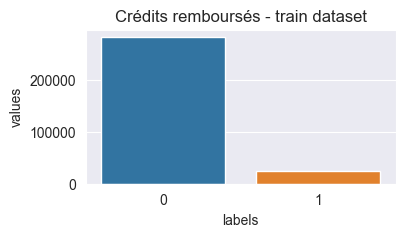

In [7]:
target = application_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': target.index,
                   'values': target.values
                  })
sns.set_style("darkgrid")
plt.figure(figsize = (4,2))
plt.title('Crédits remboursés - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()
plt.show()


- **Target** est 0 pour les crédits remboursés et 1 pour le cas contraire

- ### Repartition des contrats et des impayés en fonction du genre

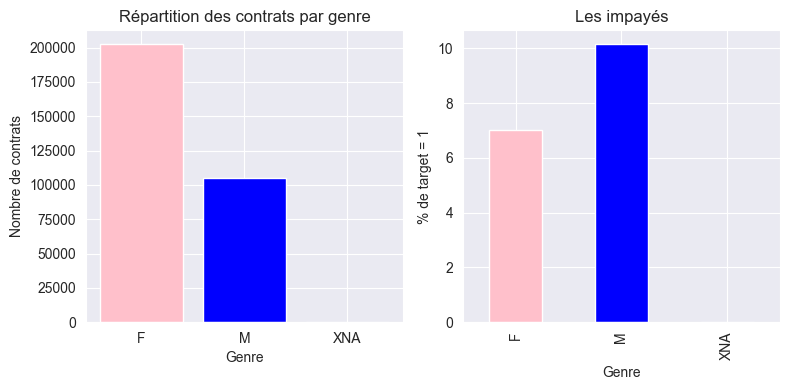

In [8]:

# Définir le style de Seaborn
sns.set_style("darkgrid")

# Créer une grille de sous-graphiques avec 1 ligne et 2 colonnes
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Premier sous-graphique : Répartition des clients par genre
colors = ['pink', 'blue']
gender_counts = application_train['CODE_GENDER'].dropna().value_counts()  # Supprimer les NaN
axes[0].bar(gender_counts.index, gender_counts.values, color=colors)
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Nombre de contrats')
axes[0].set_title('Répartition des contrats par genre')

# Deuxième sous-graphique : Niveau de remboursement selon le genre

# Supprimer les lignes avec NaN dans les colonnes 'CODE_GENDER' et 'TARGET'
cleaned_data = application_train[['CODE_GENDER', 'TARGET']].dropna()

# Calculate the percentage of target values with a value of 1 for each category in the 'CODE_GENDER' column
target_percent = (
    cleaned_data.groupby('CODE_GENDER')['TARGET']
    .mean()
    .mul(100)
)

# Define the colors for each gender
colors = ['pink' if gender == 'F' else 'blue' for gender in target_percent.index]
# Plot the percentages using a bar plot with the specified colors
target_percent.plot(kind='bar', color=colors, ax=axes[1])
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('% de target = 1')
axes[1].set_title('Les impayés')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()


- Les femmes sont les plus nombreuses à contracter des prêts
- Les hommes remboursent moins les crédits réçus

- ### Repartition des contrats et des impayés en fonction de la situation familiale

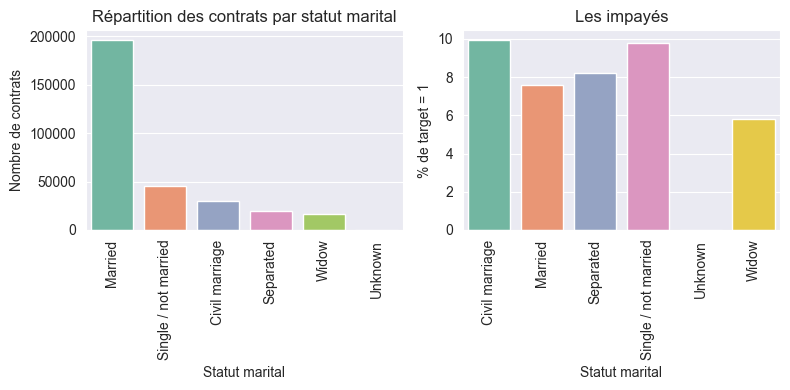

In [9]:

# Définir le style de Seaborn
sns.set_style("darkgrid")

# Créer une grille de sous-graphiques avec 1 ligne et 2 colonnes
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Premier sous-graphique : Répartition des clients par statut marital
status_counts = application_train['NAME_FAMILY_STATUS'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, ax=axes[0], palette='Set2')
axes[0].set_xlabel('Statut marital')
axes[0].set_ylabel('Nombre de contrats')
axes[0].set_title('Répartition des contrats par statut marital')

# Deuxième sous-graphique : Niveau de remboursement selon le statut marital

# Calculer le pourcentage de valeurs cibles avec une valeur de 1 pour chaque catégorie dans la colonne 'NAME_FAMILY_STATUS'
target_percent = (
    application_train.groupby('NAME_FAMILY_STATUS')['TARGET'].mean().mul(100)
)

# Utiliser une palette de couleurs de Seaborn
sns.barplot(x=target_percent.index, y=target_percent.values, ax=axes[1], palette='Set2')
axes[1].set_xlabel('Statut marital')
axes[1].set_ylabel('% de target = 1')
axes[1].set_title('Les impayés')


axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='center')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='center')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()


- ### Repartition des contrats et des impayés en fonction du nombre d'enfants à charge

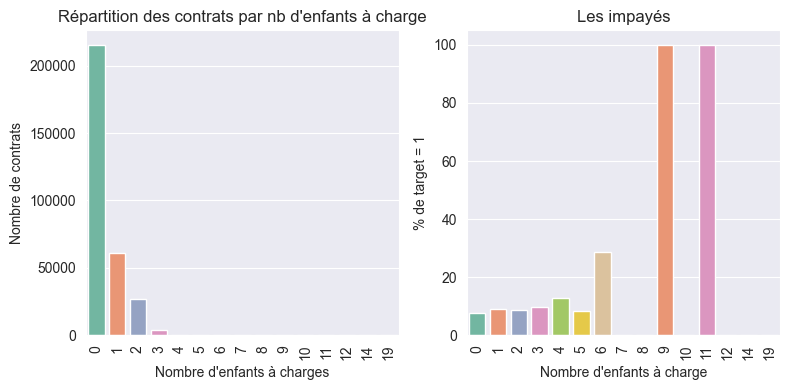

In [10]:

# Définir le style de Seaborn
sns.set_style("darkgrid")

# Créer une grille de sous-graphiques avec 1 ligne et 2 colonnes
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Premier sous-graphique : Répartition des clients par statut marital
status_counts = application_train['CNT_CHILDREN'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, ax=axes[0], palette='Set2')
axes[0].set_xlabel("Nombre d'enfants à charges")
axes[0].set_ylabel('Nombre de contrats')
axes[0].set_title("Répartition des contrats par nb d'enfants à charge")

# Deuxième sous-graphique : Niveau de remboursement selon le statut marital

# Calculer le pourcentage de valeurs cibles avec une valeur de 1 pour chaque catégorie dans la colonne 'NAME_FAMILY_STATUS'
target_percent = (
    application_train.groupby('CNT_CHILDREN')['TARGET']
    .mean()
    .mul(100)
)

# Utiliser une palette de couleurs de Seaborn
sns.barplot(x=target_percent.index, y=target_percent.values, ax=axes[1], palette='Set2')
axes[1].set_xlabel("Nombre d'enfants à charge")
axes[1].set_ylabel('% de target = 1')
axes[1].set_title('Les impayés')


axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='center')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='center')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()


- ### Repartition des contrats et des impayés en fonction de l'occupation

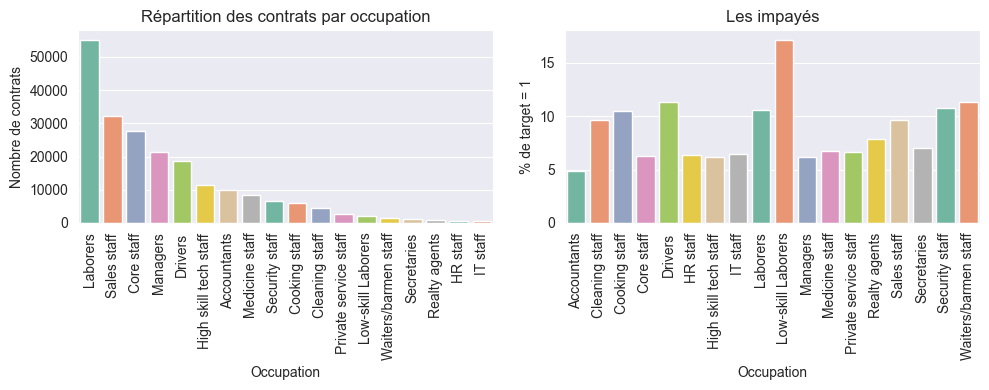

In [11]:

# Définir le style de Seaborn
sns.set_style("darkgrid")

# Créer une grille de sous-graphiques avec 1 ligne et 2 colonnes
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Premier sous-graphique : Répartition des clients par statut marital
status_counts = application_train['OCCUPATION_TYPE'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, ax=axes[0], palette='Set2')
axes[0].set_xlabel("Occupation")
axes[0].set_ylabel('Nombre de contrats')
axes[0].set_title("Répartition des contrats par occupation")

# Deuxième sous-graphique : Niveau de remboursement selon le statut marital

# Calculer le pourcentage de valeurs cibles avec une valeur de 1 pour chaque catégorie dans la colonne 'NAME_FAMILY_STATUS'
target_percent = (
    application_train.groupby('OCCUPATION_TYPE')['TARGET']
    .mean()
    .mul(100)
)

# Utiliser une palette de couleurs de Seaborn
sns.barplot(x=target_percent.index, y=target_percent.values, ax=axes[1], palette='Set2')
axes[1].set_xlabel("Occupation")
axes[1].set_ylabel('% de target = 1')
axes[1].set_title('Les impayés')


axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='center')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='center')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()


- ### Repartition des contrats et des impayés en fonction du type de revenu

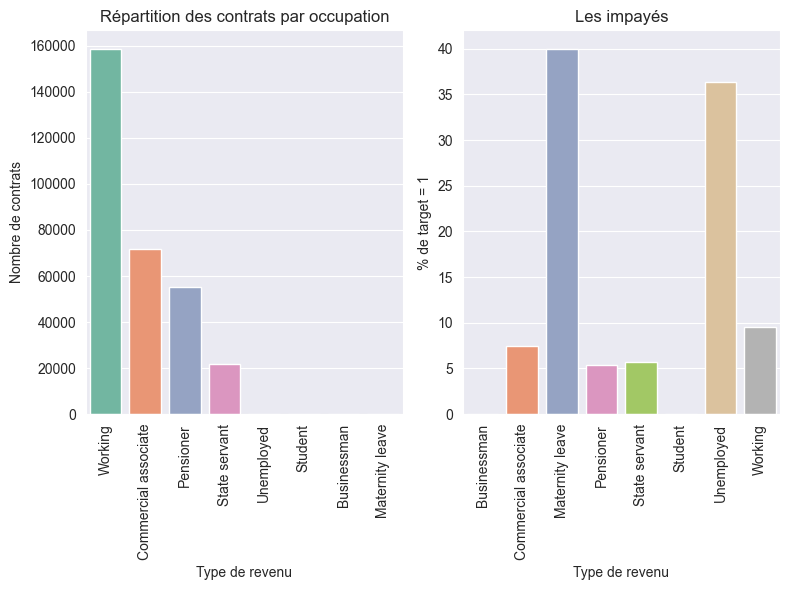

In [12]:

# Définir le style de Seaborn
sns.set_style("darkgrid")

# Créer une grille de sous-graphiques avec 1 ligne et 2 colonnes
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# Premier sous-graphique : Répartition des clients par statut marital
status_counts = application_train['NAME_INCOME_TYPE'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, ax=axes[0], palette='Set2')
axes[0].set_xlabel("Type de revenu")
axes[0].set_ylabel('Nombre de contrats')
axes[0].set_title("Répartition des contrats par occupation")

# Deuxième sous-graphique : Niveau de remboursement selon le statut marital

# Calculer le pourcentage de valeurs cibles avec une valeur de 1 pour chaque catégorie dans la colonne 'NAME_FAMILY_STATUS'
target_percent = (
    application_train.groupby('NAME_INCOME_TYPE')['TARGET']
    .mean()
    .mul(100)
)

# Utiliser une palette de couleurs de Seaborn
sns.barplot(x=target_percent.index, y=target_percent.values, ax=axes[1], palette='Set2')
axes[1].set_xlabel("Type de revenu")
axes[1].set_ylabel('% de target = 1')
axes[1].set_title('Les impayés')


axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='center')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='center')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()


- ### Repartition des contrats et des impayés en fonction du niveau d'étude

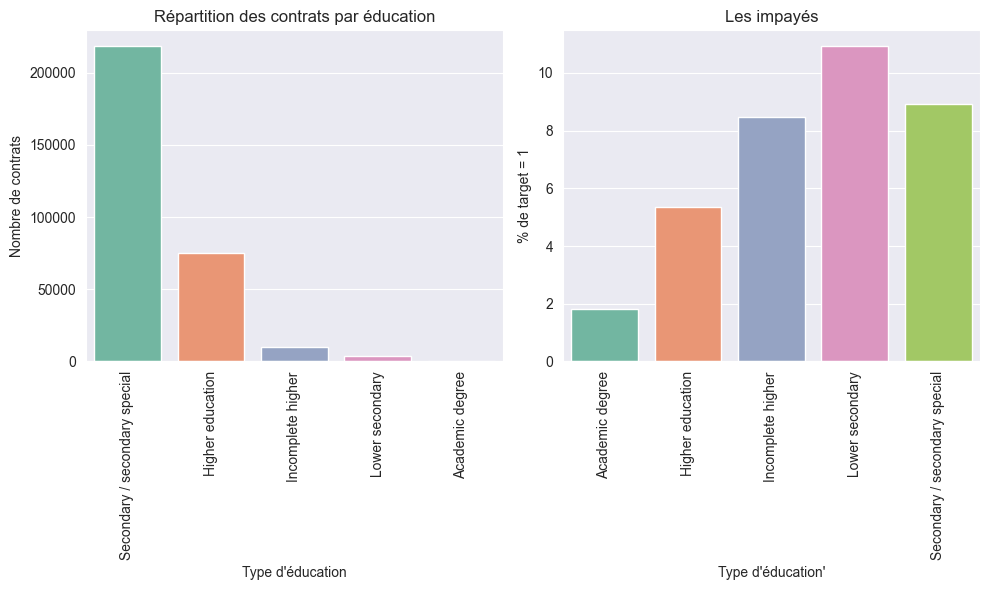

In [13]:

# Définir le style de Seaborn
sns.set_style("darkgrid")

# Créer une grille de sous-graphiques avec 1 ligne et 2 colonnes
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Premier sous-graphique : Répartition des clients par statut marital
status_counts = application_train['NAME_EDUCATION_TYPE'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, ax=axes[0], palette='Set2')
axes[0].set_xlabel("Type d'éducation")
axes[0].set_ylabel('Nombre de contrats')
axes[0].set_title("Répartition des contrats par éducation")

# Deuxième sous-graphique : Niveau de remboursement selon le statut marital

# Calculer le pourcentage de valeurs cibles avec une valeur de 1 pour chaque catégorie dans la colonne 'NAME_FAMILY_STATUS'
target_percent = (
    application_train.groupby('NAME_EDUCATION_TYPE')['TARGET']
    .mean()
    .mul(100)
)

# Utiliser une palette de couleurs de Seaborn
sns.barplot(x=target_percent.index, y=target_percent.values, ax=axes[1], palette='Set2')
axes[1].set_xlabel("Type d'éducation'")
axes[1].set_ylabel('% de target = 1')
axes[1].set_title('Les impayés')


axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='center')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='center')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()

- ### Repartition des contrats et des impayés en fonction de l'habitat

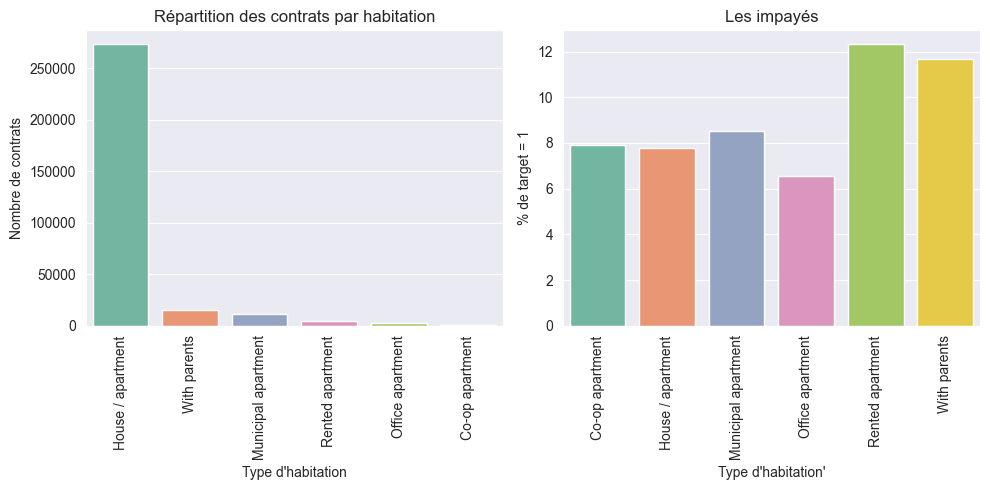

In [14]:

# Définir le style de Seaborn
sns.set_style("darkgrid")

# Créer une grille de sous-graphiques avec 1 ligne et 2 colonnes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Premier sous-graphique : Répartition des clients par statut marital
status_counts = application_train['NAME_HOUSING_TYPE'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, ax=axes[0], palette='Set2')
axes[0].set_xlabel("Type d'habitation")
axes[0].set_ylabel('Nombre de contrats')
axes[0].set_title("Répartition des contrats par habitation")

# Deuxième sous-graphique : Niveau de remboursement selon le statut marital

# Calculer le pourcentage de valeurs cibles avec une valeur de 1 pour chaque catégorie dans la colonne 'NAME_FAMILY_STATUS'
target_percent = (
    application_train.groupby('NAME_HOUSING_TYPE')['TARGET']
    .mean()
    .mul(100)
)

# Utiliser une palette de couleurs de Seaborn
sns.barplot(x=target_percent.index, y=target_percent.values, ax=axes[1], palette='Set2')
axes[1].set_xlabel("Type d'habitation'")
axes[1].set_ylabel('% de target = 1')
axes[1].set_title('Les impayés')


axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='center')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='center')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()


- ### Repartition des contrats et des impayés en fonction du type de contrat

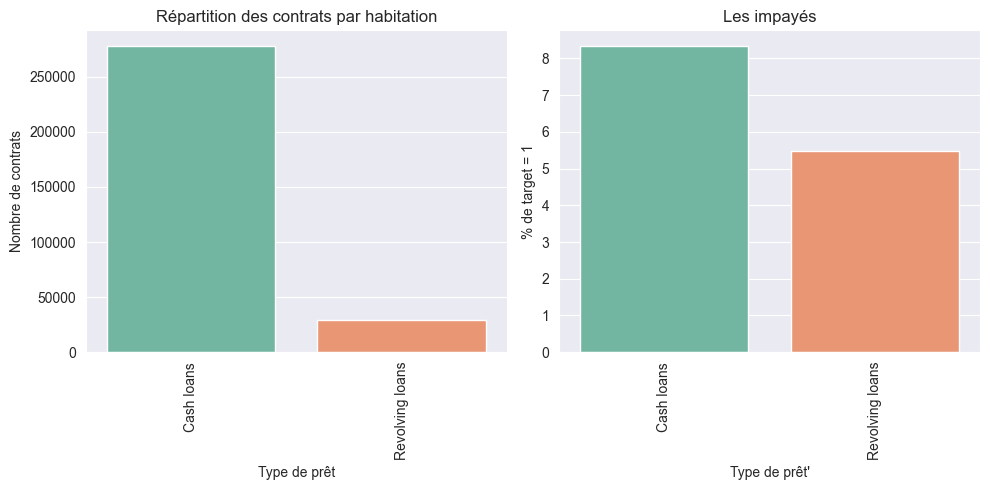

In [15]:

# Définir le style de Seaborn
sns.set_style("darkgrid")

# Créer une grille de sous-graphiques avec 1 ligne et 2 colonnes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Premier sous-graphique : Répartition des clients par statut marital
status_counts = application_train['NAME_CONTRACT_TYPE'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, ax=axes[0], palette='Set2')
axes[0].set_xlabel("Type de prêt")
axes[0].set_ylabel('Nombre de contrats')
axes[0].set_title("Répartition des contrats par habitation")

# Deuxième sous-graphique : Niveau de remboursement selon le statut marital

# Calculer le pourcentage de valeurs cibles avec une valeur de 1 pour chaque catégorie dans la colonne 'NAME_FAMILY_STATUS'
target_percent = (
    application_train.groupby('NAME_CONTRACT_TYPE')['TARGET']
    .mean()
    .mul(100)
)

# Utiliser une palette de couleurs de Seaborn
sns.barplot(x=target_percent.index, y=target_percent.values, ax=axes[1], palette='Set2')
axes[1].set_xlabel("Type de prêt'")
axes[1].set_ylabel('% de target = 1')
axes[1].set_title('Les impayés')


axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='center')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='center')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()


- ### Distribution des ages

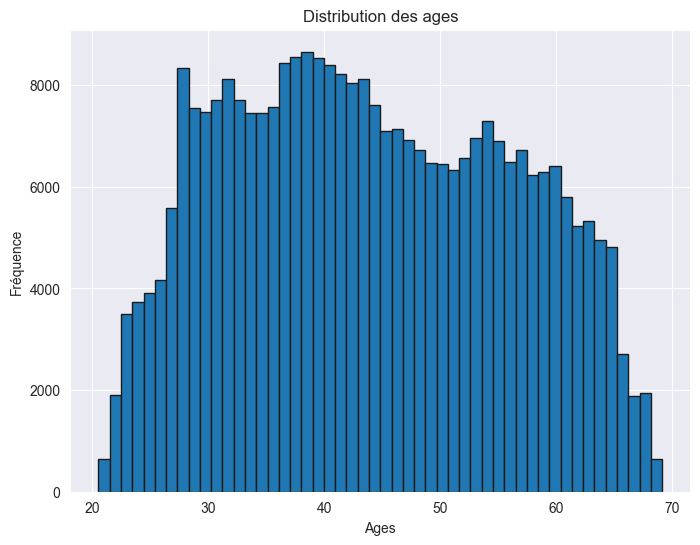

In [16]:

application_train['BIRTH_YEAR'] = (-1) * (application_train['DAYS_BIRTH'] / 365)

plt.figure(figsize=(8, 6))
plt.hist(application_train['BIRTH_YEAR'], bins=50, edgecolor='k')
plt.xlabel('Ages')
plt.ylabel('Fréquence')
plt.title('Distribution des ages')
plt.show()


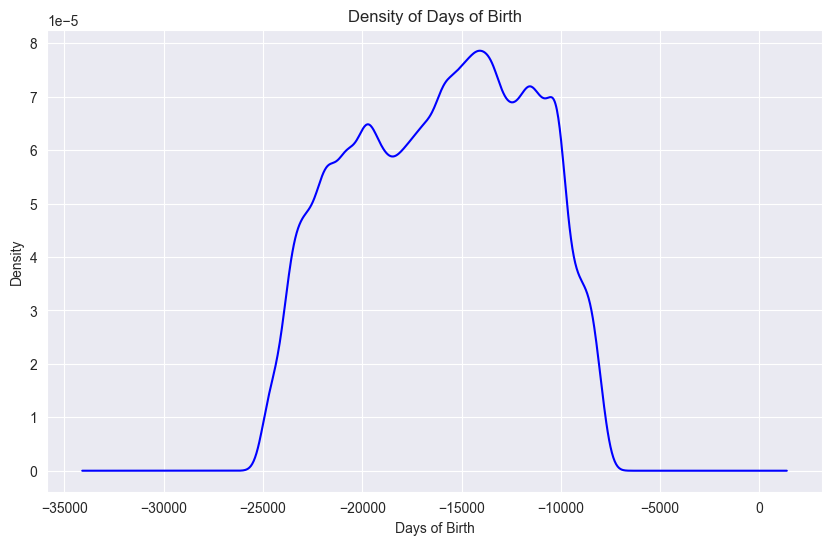

In [17]:

plt.figure(figsize=(10, 6))
application_train['DAYS_BIRTH'].plot(kind='density', color='blue')
plt.xlabel('Days of Birth')
plt.ylabel('Density')
plt.title('Density of Days of Birth')
plt.show()


- ### Durée d'emploi des clients

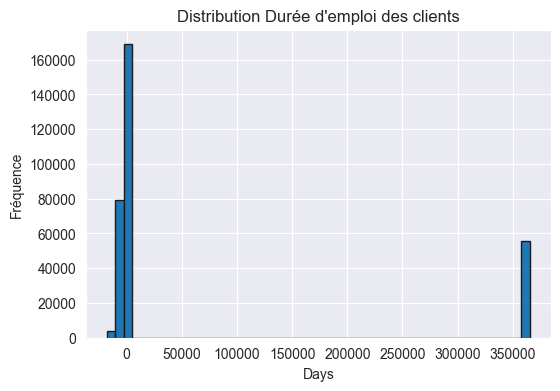

In [18]:

#application_train['DAYS_EMPLOYED'] = (-1) * (application_train['DAYS_EMPLOYED'] / 365)

plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
plt.hist(application_train['DAYS_EMPLOYED'], bins=50, edgecolor='k')
plt.xlabel('Days')
plt.ylabel('Fréquence')
plt.title("Distribution Durée d'emploi des clients")
plt.show()

# 5 - Features Engineering

### 5.1 New features application TRAIN 

In [21]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train(num_rows = None, nan_as_category = False):
    
    # Read data and merge
    df = pd.read_csv('./data/application_train.csv', nrows= num_rows)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    #df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('./data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('./data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('./data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg



# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('./data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg



# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('./data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg



def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train(num_rows)

    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        
    with timer("Full model run"):
        # Générer le fichier de soumission avec toutes les colonnes
        submission_df = df.copy()  # Créer une copie du DataFrame complet
        submission_df.to_csv(submission_file_name, index=False)  # Sauvegarder le DataFrame en tant que fichier CSV

if __name__ == "__main__":
    submission_file_name = "data_features.csv"
    with timer("Full model run"):
        main()
        

Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 26s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 29s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 19s
Installments payments df shape: (339587, 26)
Process installments payments - done in 42s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 24s
Full model run - done in 140s
Full model run - done in 288s


In [4]:
data_features = pd.read_csv('data_features.csv')

In [5]:
with open('./data/data_features.pickle', 'wb') as f:
    pickle.dump(data_features, f)

In [6]:
# Charger les data
with open('./data/data_features.pickle', 'rb') as f:
    data_features = pickle.load(f) 

In [7]:
data_features.shape

(307511, 797)

In [8]:
import re
data_features = data_features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [9]:
data_features.head()  

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,...,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_VAR,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_VAR,CC_AMT_INST_MIN_REGULARITY_MIN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_PAYMENT_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_VAR,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_VAR,CC_AMT_RECIVABLE_MIN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_RECIVABLE_VAR,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_VAR,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS

In [10]:
#data_features['YEARS_BIRTH'] = (-1) * (data_features['DAYS_BIRTH'] / 365)
#data_features['YEARS_EMPLOYED'] = (-1) * (data_features['DAYS_EMPLOYED'] / 365)

In [11]:
data_features.set_index("SK_ID_CURR", inplace=True)

In [12]:
miss_val = data_features.copy()

### Valeurs manquantes par colonne

In [13]:
# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns= {0: 'Missing Values', 1 : '% of Total Values'})
    
    # sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # print some summary information
    print('Your selected dataframe has ' + str(df.shape[1]) +
         " columns.\n"
         "There are " + str(mis_val_table_ren_columns.shape[0]) +
         " columns that have missing values.")

    # return the dataframe with missing in information
    return mis_val_table_ren_columns

In [14]:
missing_values_table(miss_val)  

Your selected dataframe has 796 columns.
There are 616 columns that have missing values.


,Missing Values,% of Total Values
REFUSED_RATE_DOWN_PAYMENT_MEAN,262341,85.3
REFUSED_RATE_DOWN_PAYMENT_MAX,262341,85.3
REFUSED_RATE_DOWN_PAYMENT_MIN,262341,85.3
REFUSED_AMT_DOWN_PAYMENT_MEAN,262341,85.3
REFUSED_AMT_DOWN_PAYMENT_MAX,262341,85.3
...,...,...
ANNUITY_INCOME_PERC,12,0.0
PAYMENT_RATE,12,0.0
CNT_FAM_MEMBERS,2,0.0
INCOME_PER_PERSON,2,0.0


### Supprimer les colonnes avec au moins 20% de valeurs manquantes

In [15]:
data_features_MV = data_features.copy()

# Calculer le pourcentage de valeurs manquantes pour chaque colonne
train_missing = (data_features_MV.isnull().sum() / len(data_features_MV)).sort_values(ascending=False)

# Liste des colonnes à supprimer
columns_to_drop = train_missing[train_missing >= 0.1].index

# Supprimer les colonnes du dataframe
data_features_MV = data_features_MV.drop(columns=columns_to_drop)



In [16]:
data_features_MV.shape

(307511, 441)

In [17]:
# Missing values (in percent)
train_missing = (data_features_MV.isnull().sum() / len(data_features_MV)).sort_values(ascending = False)
train_missing.sample(10)

PAYMENT_RATE                                                 0.000039
PREV_NAME_YIELD_GROUP_low_normal_MEAN                        0.053507
INSTAL_DBD_MAX                                               0.051601
INSTAL_AMT_INSTALMENT_MEAN                                   0.051601
INSTAL_PAYMENT_PERC_MAX                                      0.051627
PREV_PRODUCT_COMBINATION_POShouseholdwithoutinterest_MEAN    0.053507
AMT_ANNUITY                                                  0.000039
PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN                         0.053507
WALLSMATERIAL_MODE_Mixed                                     0.000000
PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN                      0.053507
dtype: float64

### Suppression des ligne NaN

In [21]:
data_features_WMV = data_features_MV.copy()

# Drop nan
data_features_WMV.dropna(axis=0, inplace=True)
data_features_WMV.shape

(284891, 441)

In [22]:
# Sauvegarder les données
with open('./data/data_features_WMV.pickle', 'wb') as f:
    pickle.dump(data_features_WMV, f)

### Suppression des variables fortement correlées avec la cible

In [23]:
# Charger les données
with open('./data/data_features_WMV.pickle', 'rb') as f:
    data_features_WMV = pickle.load(f) 

In [24]:

# Absolute value correlation matrix
corr_matrix = data_features_WMV.corr().abs()
corr_matrix.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,...,PREV_NAME_PORTFOLIO_Cars_MEAN,PREV_NAME_PORTFOLIO_Cash_MEAN,PREV_NAME_PORTFOLIO_POS_MEAN,PREV_NAME_PORTFOLIO_XNA_MEAN,PREV_NAME_PORTFOLIO_nan_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_NAME_PRODUCT_TYPE_xsell_MEAN,PREV_NAME_PRODUCT_TYPE_nan_MEAN,PREV_CHANNEL_TYPE_APCashloan_MEAN,PREV_CHANNEL_TYPE_Cardealer_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_CHANNEL_TYPE_Contactcenter_MEAN,PREV_CHANNEL_TYPE_Countrywide_MEAN,PREV_CHANNEL_TYPE_Creditandcashoffices_MEAN,PREV_CHANNEL_TYPE_RegionalLocal_MEAN,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_CHANNEL_TYPE_nan_MEAN,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN,PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN,PREV_NAME_SELLER_INDUSTRY_Construction_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN,PREV_NAME_SELLER_INDUSTRY_Industry_MEAN,PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN,PREV_NAME_SELLER_INDUSTRY_MLMpar

In [25]:
# Upper triangle of correlations

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1))
upper.head()


,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,...,PREV_NAME_PORTFOLIO_Cars_MEAN,PREV_NAME_PORTFOLIO_Cash_MEAN,PREV_NAME_PORTFOLIO_POS_MEAN,PREV_NAME_PORTFOLIO_XNA_MEAN,PREV_NAME_PORTFOLIO_nan_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,PREV_NAME_PRODUCT_TYPE_xsell_MEAN,PREV_NAME_PRODUCT_TYPE_nan_MEAN,PREV_CHANNEL_TYPE_APCashloan_MEAN,PREV_CHANNEL_TYPE_Cardealer_MEAN,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_CHANNEL_TYPE_Contactcenter_MEAN,PREV_CHANNEL_TYPE_Countrywide_MEAN,PREV_CHANNEL_TYPE_Creditandcashoffices_MEAN,PREV_CHANNEL_TYPE_RegionalLocal_MEAN,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_CHANNEL_TYPE_nan_MEAN,PREV_NAME_SELLER_INDUSTRY_Autotechnology_MEAN,PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN,PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN,PREV_NAME_SELLER_INDUSTRY_Construction_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN,PREV_NAME_SELLER_INDUSTRY_Industry_MEAN,PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN,PREV_NAME_SELLER_INDUSTRY_MLMpar

In [26]:
# Threshold for removing correlated variables
threshold = 0.8

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))


There are 83 columns to remove.


In [27]:
data_features_WMV_corr = data_features_WMV.copy()

data_features_WMV_corr = data_features_WMV_corr.drop(columns = to_drop)
#test = test.drop(columns = to_drop)

print('Training data shape: ', data_features_WMV_corr.shape)
#print('Testing shape: ', test.shape) 

Training data shape:  (284891, 358)


### Verification niveau des valeurs manquantes

In [28]:
# Train missing values (in percent)
train_missing = (data_features_WMV_corr.isnull().sum() / len(data_features_WMV_corr)).sort_values(ascending = False)
train_missing.head()


TARGET                                                   0.0
PREV_NAME_CASH_LOAN_PURPOSE_Paymentsonotherloans_MEAN    0.0
PREV_CODE_REJECT_REASON_SYSTEM_MEAN                      0.0
PREV_CODE_REJECT_REASON_SCOFR_MEAN                       0.0
PREV_CODE_REJECT_REASON_SCO_MEAN                         0.0
dtype: float64

In [29]:
data_features_WMV_corr.head() 

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE_Cashloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,...,PREV_NAME_PAYMENT_TYPE_Cashlessfromtheaccountoftheemployer_MEAN,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_PAYMENT_TYPE_nan_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,PREV_CODE_REJECT_REASON_VERIF_MEAN,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_CODE_REJECT_REASON_nan_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_Other_A_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_CLIENT_TYPE_nan_MEAN,PREV_NAME_GOODS_CATEGORY_AdditionalService_MEAN,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_AudioVid

In [30]:

# Sauvegarder les données
with open('./data/data_for_modelling.pickle', 'wb') as f:
    pickle.dump(data_features_WMV_corr, f)

In [31]:
# Charger les données
with open('./data/data_for_modelling.pickle', 'rb') as f:
    data_for_modelling = pickle.load(f) 

In [32]:
data_for_modelling.shape

(284891, 358)

In [33]:
clean_train_df = data_for_modelling.copy()
clean_train_df.shape 

(284891, 358)

# MODÉLISATION

## 1. COMPARAISON DE PLUSIEURS MODÈLES

In [11]:
# Charger les données
with open('./data/data_for_modelling.pickle', 'rb') as f:
    data_for_modelling = pickle.load(f)

In [12]:
data_for_modelling.head() 

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE_Cashloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,...,PREV_NAME_PAYMENT_TYPE_Cashlessfromtheaccountoftheemployer_MEAN,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_PAYMENT_TYPE_nan_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,PREV_CODE_REJECT_REASON_VERIF_MEAN,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_CODE_REJECT_REASON_nan_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_Other_A_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_CLIENT_TYPE_nan_MEAN,PREV_NAME_GOODS_CATEGORY_AdditionalService_MEAN,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_AudioVid

### 1.1 Choix d'un échantillon

In [13]:
payment = data_for_modelling[data_for_modelling.TARGET == 0]
defaut_payment = data_for_modelling[data_for_modelling.TARGET == 1]
print(f'Total des remboursement == 0: {len(payment)}')
print(f'Total des defauts de remboursement == 1: {len(defaut_payment)}')


Total des remboursement == 0: 261654
Total des defauts de remboursement == 1: 23237


In [14]:
# Échantillon aléatoire correspondant à environ 15% du fichier 
n_rows = payment.shape[0]
echantillon=round(n_rows*0.15)
payment_ech=payment.sample(n=echantillon)

n_rows = defaut_payment.shape[0]
echantillon=round(n_rows*0.15)
defaut_payment_ech=defaut_payment.sample(n=echantillon)

print(f'Total des remboursement == 0: {len(payment_ech)}')
print(f'Total des defauts de remboursement == 1: {len(defaut_payment_ech)}')

Total des remboursement == 0: 39248
Total des defauts de remboursement == 1: 3486


In [15]:
clean_train_ech = pd.concat([payment_ech, defaut_payment_ech])

In [16]:
clean_train_ech.shape

(42734, 358)

In [17]:
clean_train_ech.head() 

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE_Cashloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,...,PREV_NAME_PAYMENT_TYPE_Cashlessfromtheaccountoftheemployer_MEAN,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_PAYMENT_TYPE_nan_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,PREV_CODE_REJECT_REASON_VERIF_MEAN,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_CODE_REJECT_REASON_nan_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_Other_A_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_CLIENT_TYPE_nan_MEAN,PREV_NAME_GOODS_CATEGORY_AdditionalService_MEAN,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_AudioVid

### 1.2 Division de l'échantillon

In [59]:
X = clean_train_ech.copy()
y = X['TARGET']
#X.drop(columns=['TARGET'],inplace=True)
X.drop(columns=['TARGET'],inplace=True)

X_test,X_train,y_test,y_train=train_test_split(X,y,test_size=0.20)

# StandardScaler
# Fit on the training data
scaler = StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

## Score métier

**Définition d'une métrique "métier"**

Il faut créer une métrique pertinente concernant notre problématique pour comparer nos algorithmes. Une société de crédit cherche à "maximiser" ses gains. 

On va donc créer un score en pondérant les différents cas possibles qui sera normalisé entre 0 et 1 par une normalisation min-max feature scalling avec :
- Faux Négatifs (FN) = -100 .. **Accord de prêts malgré que le client ne remboursera pas (perte pour la banque)** 
- Vrais Positifs (TP) = 0  ... **Refus de prêt à des clients incapables de rempbourser (sauvegarde de capital)** 
- Vrais Négatifs (TN) = 10 .. **Prêt accordé à des clients capables de rembourser (gain d'argent pour la banque)** 
- Faux positifs (FP) = -1 ... **Rejeter un clients qui aurait pu rembourser (perte d'argent pour la banque)** 


In [18]:
def cf_mat(y_test, y_pred, size):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=size)
  
    #plt.subplot(221)
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Confusion Matrix')
    cf_matrix = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='RdPu')
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                    bottom=False, top = False, labeltop=True)

    plt.show()

    print('True negative = ', TN)
    print('False positive = ', FP)
    print('False negative = ', FN)
    print('True positive = ', TP)

    return TN, FP, FN, TP


In [19]:
def score(TN, FP, FN, TP, coef_TN, coef_FP, coef_FN, coef_TP):
    total = (coef_TN*TN + coef_FP*FP + coef_FN*FN + coef_TP*TP)
    #calcul du gain maximal que peut avoir la banque quand il n'y a pas de perte d'argent. C'est à dire que le modèle ne détecte que TN et les TP.
    max_gain = (TN + FP)*coef_TN + (TP + FN)*coef_TP
    #calcul du gain minimal (perte) que peut avoir la banque quand il n'y a pas de gain d'argent. C'est à dire que le modèle ne détecte que FN et les FP.
    min_gain = (TN + FP)*coef_FP + (TP + FN)*coef_FN
    #normalisation min-max feature scalling : score= (tot-min)/(max-min) https://en.wikipedia.org/wiki/Normalization_(statistics) 
    score_metier = (total - min_gain)/(max_gain - min_gain)

    return score_metier



### Évaluation Dummy Classifier

In [87]:
X = clean_train_ech.copy()
y = X['TARGET']
#X.drop(columns=['TARGET'],inplace=True)
X.drop(columns=['TARGET'],inplace=True)

X_test,X_train,y_test,y_train=train_test_split(X,y,test_size=0.20)

# StandardScaler
# Fit on the training data
scaler = StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

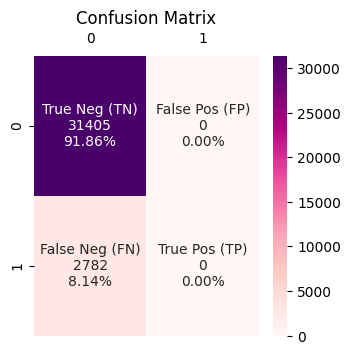

True negative =  31405
False positive =  0
False negative =  2782
True positive =  0


In [88]:
# Initialise une liste vide dfs qui sera utilisée pour stocker les DataFrames
dfs = []

# Initialise des listes vides results et names qui seront utilisées pour stocker
# les résultats de validation croisée et les noms des modèles, respectivement.
results = []
names = []

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'fbeta': make_scorer(fbeta_score, average='weighted', beta=3),
    'Score_Metier': make_scorer(lambda y_test, y_pred: score_metier)  # Utilisez make_scorer pour créer un scorer à partir de la fonction score_gain
    }

# Initialise le modèle LogisticRegression
model = DummyClassifier()

# Démarre un chronomètre pour suivre le temps pris par le modèle.
start_time_model = time.time()

# Définit un objet KFold avec 5 divisions pour la validation croisée.
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

# Effectue la validation croisée en utilisant la fonction cross_validate,
# qui calcule les métriques de performance spécifiées pour le modèle donné,
# les données d'entraînement (X_train et y_train).
cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)

# Ajuste le modèle sur les données d'entraînement (X_train et y_train).
clf = model.fit(X_train, y_train)

# Prédit les valeurs cibles pour les données de test (X_test).
y_pred = clf.predict(X_test)

# Matrice de confusion 
TN, FP, FN, TP = cf_mat(y_test, y_pred, (8,8))

# Score metier
score_metier = score(TN, FP, FN, TP, 10, -1, -100, 0)

# Add score_gain to DataFrame
cv_results['test_sm'] = score_metier


# Ajoute les résultats de la validation croisée, le nom du modèle et le DataFrame
# des résultats aux listes respectives (results, names et dfs)
results.append(cv_results)
names.append('DummyClassifier')
df = pd.DataFrame(cv_results)
df['model'] = 'DummyClassifier'
dfs.append(df)

# Concatène tous les DataFrames de la liste dfs en un seul DataFrame final,
# en ignorant l'indice d'origine.
final = pd.concat(dfs, ignore_index=True)


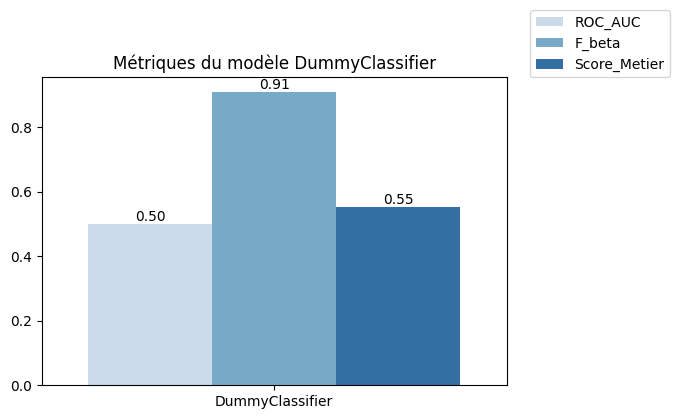

In [89]:

# extraire les colonnes 'model', 'test_roc_auc' et 'test_fbeta' du 
# DataFrame 'final' et les assigne à la variable 'evaluation'.
evaluation = final[['model','test_roc_auc','test_fbeta', 'test_sm']]

# regrouper les données de 'evaluation' par la colonne 'model' 
# et calculer la moyenne des autres colonnes pour chaque groupe. 
# Le résultat est assigné à la variable 'eval_ag'.
eval_ag = evaluation.groupby("model").mean()

# assigner les valeurs de l'index de 'eval_ag' à la colonne 'model'. 
# Cela permet d'avoir une colonne 'model' contenant les mêmes valeurs que l'index
eval_ag['model'] = eval_ag.index

#  renommer les colonnes 'test_roc_auc' et 'test_fbeta' de 'eval_ag' en 'ROC_AUC' 
# et 'F_beta' respectivement.
eval_ag.rename(columns={'test_roc_auc': 'ROC_AUC',
                        'test_fbeta':'F_beta',
                        'test_sm': 'Score_Metier'}, inplace=True)

# transforme le DataFrame 'eval_ag' en format tabulaire en utilisant la fonction melt(). 
# La colonne 'model' est spécifiée comme variable d'identification.
stack = eval_ag.melt(id_vars=['model'])

# Définir une palette personnalisée avec les couleurs souhaitées
custom_palette = sns.color_palette("Blues", 3)

# Créer une figure et des axes pour le graphique à afficher
fig, axes = plt.subplots(figsize=(6, 4))
plt.title('Métriques du modèle DummyClassifier', fontsize=12)

# Utiliser la palette personnalisée dans le graphique à barres
ax = sns.barplot(x='model', y='value', hue='variable', data=stack, ax=axes, palette=custom_palette)

# Ajouter les étiquettes de valeur au-dessus des barres
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.01, "%.2f" % p.get_height(), ha="center")

# Rotation des étiquettes sur l'axe x si nécessaire
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

plt.xlabel("")
plt.ylabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.)
plt.draw()



### Évaluation du modèle RandomForest

In [90]:
X = clean_train_ech.copy()
y = X['TARGET']
#X.drop(columns=['TARGET'],inplace=True)
X.drop(columns=['TARGET'],inplace=True)

X_test,X_train,y_test,y_train=train_test_split(X,y,test_size=0.20)

# StandardScaler
# Fit on the training data
scaler = StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

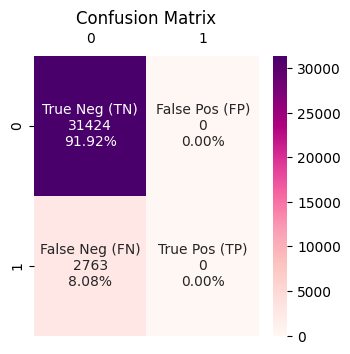

True negative =  31424
False positive =  0
False negative =  2763
True positive =  0


In [91]:
# Initialise une liste vide dfs qui sera utilisée pour stocker les DataFrames
dfs = []

# Initialise des listes vides results et names qui seront utilisées pour stocker
# les résultats de validation croisée et les noms des modèles, respectivement.
results = []
names = []

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'fbeta': make_scorer(fbeta_score, average='weighted', beta=3),
    'Score_Metier': make_scorer(lambda y_test, y_pred: score_metier)  # Utilisez make_scorer pour créer un scorer à partir de la fonction score_gain
    }

# Initialise le modèle LogisticRegression
model = RandomForestClassifier()

# Démarre un chronomètre pour suivre le temps pris par le modèle.
start_time_model = time.time()

# Définit un objet KFold avec 5 divisions pour la validation croisée.
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

# Effectue la validation croisée en utilisant la fonction cross_validate,
# qui calcule les métriques de performance spécifiées pour le modèle donné,
# les données d'entraînement (X_train et y_train).
cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)

# Ajuste le modèle sur les données d'entraînement (X_train et y_train).
clf = model.fit(X_train, y_train)

# Prédit les valeurs cibles pour les données de test (X_test).
y_pred = clf.predict(X_test)


# Matrice de confusion 
TN, FP, FN, TP = cf_mat(y_test, y_pred, (8,8))

# Score metier
score_metier = score(TN, FP, FN, TP, 10, -1, -100, 0)

# Add score_gain to DataFrame
cv_results['test_sm'] = score_metier


# Ajoute les résultats de la validation croisée, le nom du modèle et le DataFrame
# des résultats aux listes respectives (results, names et dfs)
results.append(cv_results)
names.append('RandomForestClassifier')
df = pd.DataFrame(cv_results)
df['model'] = 'RandomForestClassifier'
dfs.append(df)

# Concatène tous les DataFrames de la liste dfs en un seul DataFrame final,
# en ignorant l'indice d'origine.
final = pd.concat(dfs, ignore_index=True)


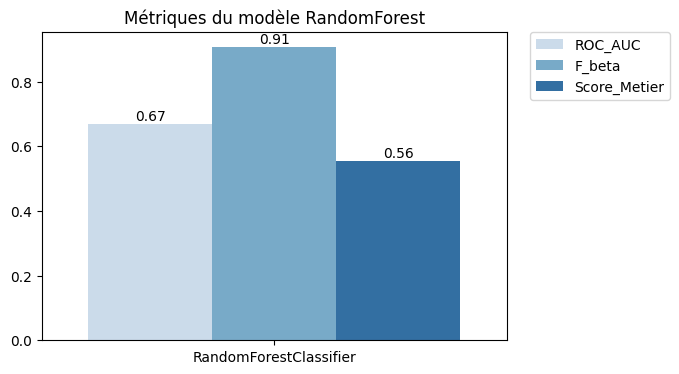

In [92]:
# extraire les colonnes 'model', 'test_roc_auc' et 'test_fbeta' du 
# DataFrame 'final' et les assigne à la variable 'evaluation'.
evaluation = final[['model','test_roc_auc','test_fbeta', 'test_sm']]

# regrouper les données de 'evaluation' par la colonne 'model' 
# et calculer la moyenne des autres colonnes pour chaque groupe. 
# Le résultat est assigné à la variable 'eval_ag'.
eval_ag = evaluation.groupby("model").mean()

# assigner les valeurs de l'index de 'eval_ag' à la colonne 'model'. 
# Cela permet d'avoir une colonne 'model' contenant les mêmes valeurs que l'index
eval_ag['model'] = eval_ag.index

#  renommer les colonnes 'test_roc_auc' et 'test_fbeta' de 'eval_ag' en 'ROC_AUC' 
# et 'F_beta' respectivement.
eval_ag.rename(columns={'test_roc_auc': 'ROC_AUC',
                        'test_fbeta':'F_beta',
                        'test_sm': 'Score_Metier'}, inplace=True)

# transforme le DataFrame 'eval_ag' en format tabulaire en utilisant la fonction melt(). 
# La colonne 'model' est spécifiée comme variable d'identification.
stack=eval_ag.melt(id_vars=['model'])

# Définir une palette personnalisée avec les couleurs souhaitées
custom_palette = sns.color_palette("Blues", 3)


# Créer une figure et des axes pour le graphique à afficher
fig, axes = plt.subplots(figsize=(6, 4))
plt.title('Métriques du modèle RandomForest', fontsize=12)

# Utiliser la palette personnalisée dans le graphique à barres
ax = sns.barplot(x='model', y='value', hue='variable', data=stack, ax=axes, palette=custom_palette)

# Ajouter les étiquettes de valeur au-dessus des barres
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.01, "%.2f" % p.get_height(), ha="center")

# Rotation des étiquettes sur l'axe x si nécessaire
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

plt.xlabel("")
plt.ylabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.draw()


### Évaluation du modèle LogisticRegression

In [93]:
X = clean_train_ech.copy()
y = X['TARGET']
#X.drop(columns=['TARGET'],inplace=True)
X.drop(columns=['TARGET'],inplace=True)

X_test,X_train,y_test,y_train=train_test_split(X,y,test_size=0.20)

# StandardScaler
# Fit on the training data
scaler = StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

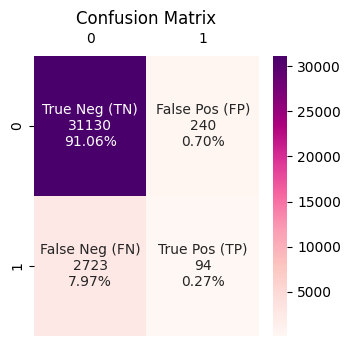

True negative =  31130
False positive =  240
False negative =  2723
True positive =  94


In [94]:
# Initialise une liste vide dfs qui sera utilisée pour stocker les DataFrames
dfs = []

# Initialise des listes vides results et names qui seront utilisées pour stocker
# les résultats de validation croisée et les noms des modèles, respectivement.
results = []
names = []

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'fbeta': make_scorer(fbeta_score, average='weighted', beta=3),
    'Score_Metier': make_scorer(lambda y_test, y_pred: score_metier)  # Utilisez make_scorer pour créer un scorer à partir de la fonction score_gain
    }

# Initialise le modèle LogisticRegression
model = LogisticRegression()

# Démarre un chronomètre pour suivre le temps pris par le modèle.
start_time_model = time.time()

# Définit un objet KFold avec 5 divisions pour la validation croisée.
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

# Effectue la validation croisée en utilisant la fonction cross_validate,
# qui calcule les métriques de performance spécifiées pour le modèle donné,
# les données d'entraînement (X_train et y_train).
cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)

# Ajuste le modèle sur les données d'entraînement (X_train et y_train).
clf = model.fit(X_train, y_train)

# Prédit les valeurs cibles pour les données de test (X_test).
y_pred = clf.predict(X_test)

# Matrice de confusion 
# Matrice de confusion 
TN, FP, FN, TP = cf_mat(y_test, y_pred, (8,8))

# Score metier
score_metier = score(TN, FP, FN, TP, 10, -1, -100, 0)

# Add score_gain to DataFrame
cv_results['test_sm'] = score_metier


# Ajoute les résultats de la validation croisée, le nom du modèle et le DataFrame
# des résultats aux listes respectives (results, names et dfs)
results.append(cv_results)
names.append('LogisticRegression')
df = pd.DataFrame(cv_results)
df['model'] = 'LogisticRegression'
dfs.append(df)

# Concatène tous les DataFrames de la liste dfs en un seul DataFrame final,
# en ignorant l'indice d'origine.
final = pd.concat(dfs, ignore_index=True)


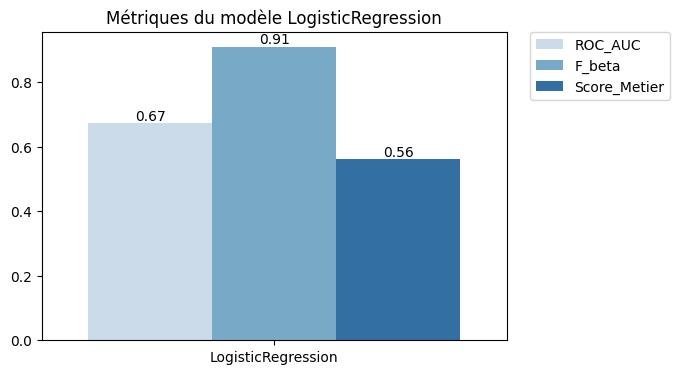

In [95]:
# extraire les colonnes 'model', 'test_roc_auc' et 'test_fbeta' du 
# DataFrame 'final' et les assigne à la variable 'evaluation'.
evaluation = final[['model','test_roc_auc','test_fbeta', 'test_sm']]

# regrouper les données de 'evaluation' par la colonne 'model' 
# et calculer la moyenne des autres colonnes pour chaque groupe. 
# Le résultat est assigné à la variable 'eval_ag'.
eval_ag = evaluation.groupby("model").mean()

# assigner les valeurs de l'index de 'eval_ag' à la colonne 'model'. 
# Cela permet d'avoir une colonne 'model' contenant les mêmes valeurs que l'index
eval_ag['model'] = eval_ag.index

#  renommer les colonnes 'test_roc_auc' et 'test_fbeta' de 'eval_ag' en 'ROC_AUC' 
# et 'F_beta' respectivement.
eval_ag.rename(columns={'test_roc_auc': 'ROC_AUC',
                        'test_fbeta':'F_beta',
                        'test_sm': 'Score_Metier'}, inplace=True)

# transforme le DataFrame 'eval_ag' en format tabulaire en utilisant la fonction melt(). 
# La colonne 'model' est spécifiée comme variable d'identification.
stack=eval_ag.melt(id_vars=['model'])

# Définir une palette personnalisée avec les couleurs souhaitées
custom_palette = sns.color_palette("Blues", 3)


# Créer une figure et des axes pour le graphique à afficher
fig, axes = plt.subplots(figsize=(6, 4))
plt.title('Métriques du modèle LogisticRegression', fontsize=12)

# Utiliser la palette personnalisée dans le graphique à barres
ax = sns.barplot(x='model', y='value', hue='variable', data=stack, ax=axes, palette=custom_palette)

# Ajouter les étiquettes de valeur au-dessus des barres
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.01, "%.2f" % p.get_height(), ha="center")

# Rotation des étiquettes sur l'axe x si nécessaire
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

plt.xlabel("")
plt.ylabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.draw()


### Évaluation du modèle XGBClassifier

In [96]:
X = clean_train_ech.copy()
y = X['TARGET']
#X.drop(columns=['TARGET'],inplace=True)
X.drop(columns=['TARGET'],inplace=True)

X_test,X_train,y_test,y_train=train_test_split(X,y,test_size=0.20)

# StandardScaler
# Fit on the training data
scaler = StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

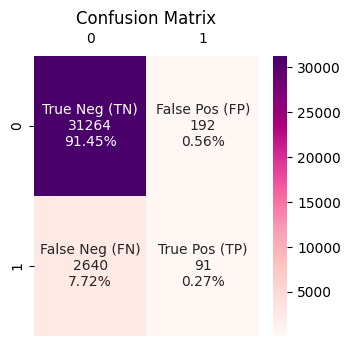

True negative =  31264
False positive =  192
False negative =  2640
True positive =  91


In [97]:
# Initialise une liste vide dfs qui sera utilisée pour stocker les DataFrames
dfs = []

# Initialise des listes vides results et names qui seront utilisées pour stocker
# les résultats de validation croisée et les noms des modèles, respectivement.
results = []
names = []

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'fbeta': make_scorer(fbeta_score, average='weighted', beta=3),
    'Score_Metier': make_scorer(lambda y_test, y_pred: score_metier)  # Utilisez make_scorer pour créer un scorer à partir de la fonction score_gain
    }

# Initialise le modèle LogisticRegression
model = XGBClassifier()

# Démarre un chronomètre pour suivre le temps pris par le modèle.
start_time_model = time.time()

# Définit un objet KFold avec 5 divisions pour la validation croisée.
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

# Effectue la validation croisée en utilisant la fonction cross_validate,
# qui calcule les métriques de performance spécifiées pour le modèle donné,
# les données d'entraînement (X_train et y_train).
cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)

# Ajuste le modèle sur les données d'entraînement (X_train et y_train).
clf = model.fit(X_train, y_train)

# Prédit les valeurs cibles pour les données de test (X_test).
y_pred = clf.predict(X_test)

# Matrice de confusion 
TN, FP, FN, TP = cf_mat(y_test, y_pred, (8,8))

# Score metier
score_metier = score(TN, FP, FN, TP, 10, -1, -100, 0)

# Add score_gain to DataFrame
cv_results['test_sm'] = score_metier

# Ajoute les résultats de la validation croisée, le nom du modèle et le DataFrame
# des résultats aux listes respectives (results, names et dfs)
results.append(cv_results)
names.append('XGBClassifier')
df = pd.DataFrame(cv_results)
df['model'] = 'XGBClassifier'
dfs.append(df)

# Concatène tous les DataFrames de la liste dfs en un seul DataFrame final,
# en ignorant l'indice d'origine.
final = pd.concat(dfs, ignore_index=True)


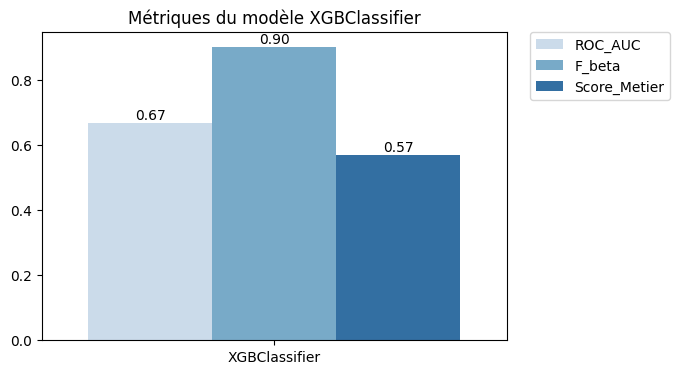

In [98]:
# extraire les colonnes 'model', 'test_roc_auc' et 'test_fbeta' du 
# DataFrame 'final' et les assigne à la variable 'evaluation'.
evaluation = final[['model','test_roc_auc','test_fbeta', 'test_sm']]

# regrouper les données de 'evaluation' par la colonne 'model' 
# et calculer la moyenne des autres colonnes pour chaque groupe. 
# Le résultat est assigné à la variable 'eval_ag'.
eval_ag = evaluation.groupby("model").mean()

# assigner les valeurs de l'index de 'eval_ag' à la colonne 'model'. 
# Cela permet d'avoir une colonne 'model' contenant les mêmes valeurs que l'index
eval_ag['model'] = eval_ag.index

#  renommer les colonnes 'test_roc_auc' et 'test_fbeta' de 'eval_ag' en 'ROC_AUC' 
# et 'F_beta' respectivement.
eval_ag.rename(columns={'test_roc_auc': 'ROC_AUC',
                        'test_fbeta':'F_beta',
                        'test_sm': 'Score_Metier'}, inplace=True)

# transforme le DataFrame 'eval_ag' en format tabulaire en utilisant la fonction melt(). 
# La colonne 'model' est spécifiée comme variable d'identification.
stack=eval_ag.melt(id_vars=['model'])

# Définir une palette personnalisée avec les couleurs souhaitées
custom_palette = sns.color_palette("Blues", 3)


# Créer une figure et des axes pour le graphique à afficher
fig, axes = plt.subplots(figsize=(6, 4))
plt.title('Métriques du modèle XGBClassifier', fontsize=12)

# Utiliser la palette personnalisée dans le graphique à barres
ax = sns.barplot(x='model', y='value', hue='variable', data=stack, ax=axes, palette=custom_palette)

# Ajouter les étiquettes de valeur au-dessus des barres
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.01, "%.2f" % p.get_height(), ha="center")

# Rotation des étiquettes sur l'axe x si nécessaire
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

plt.xlabel("")
plt.ylabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.draw()


### Évaluation du modèle LGBMClassifier

In [20]:
X = clean_train_ech.copy()
y = X['TARGET']
#X.drop(columns=['TARGET'],inplace=True)
X.drop(columns=['TARGET'],inplace=True)

X_test,X_train,y_test,y_train=train_test_split(X,y,test_size=0.20)

# StandardScaler
# Fit on the training data
scaler = StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

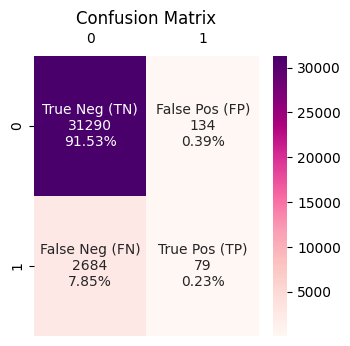

True negative =  31290
False positive =  134
False negative =  2684
True positive =  79


In [21]:
# Initialise une liste vide dfs qui sera utilisée pour stocker les DataFrames
dfs = []

# Initialise des listes vides results et names qui seront utilisées pour stocker
# les résultats de validation croisée et les noms des modèles, respectivement.
results = []
names = []

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'fbeta': make_scorer(fbeta_score, average='weighted', beta=3),
    'Score_Metier': make_scorer(lambda y_test, y_pred: score_metier)  # Utilisez make_scorer pour créer un scorer à partir de la fonction score_gain
    }

# Initialise le modèle 
model = LGBMClassifier()

# Démarre un chronomètre pour suivre le temps pris par le modèle.
start_time_model = time.time()

# Définit un objet KFold avec 5 divisions pour la validation croisée.
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

# Effectue la validation croisée en utilisant la fonction cross_validate,
# qui calcule les métriques de performance spécifiées pour le modèle donné,
# les données d'entraînement (X_train et y_train).
cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)

# Ajuste le modèle sur les données d'entraînement (X_train et y_train).
clf = model.fit(X_train, y_train)

# Prédit les valeurs cibles pour les données de test (X_test).
y_pred = clf.predict(X_test)

# Matrice de confusion 
TN, FP, FN, TP = cf_mat(y_test, y_pred, (8,8))

# Score metier
score_metier = score(TN, FP, FN, TP, 10, -1, -100, 0)

# Add score_gain to DataFrame
cv_results['test_sm'] = score_metier


# Ajoute les résultats de la validation croisée, le nom du modèle et le DataFrame
# des résultats aux listes respectives (results, names et dfs)
results.append(cv_results)
names.append('LGBMClassifier')
df = pd.DataFrame(cv_results)
df['model'] = 'LGBMClassifier'
dfs.append(df)

# Concatène tous les DataFrames de la liste dfs en un seul DataFrame final,
# en ignorant l'indice d'origine.
final = pd.concat(dfs, ignore_index=True)


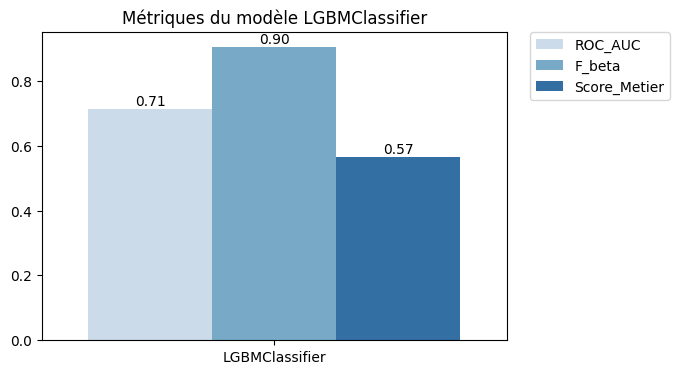

In [22]:
# extraire les colonnes 'model', 'test_roc_auc' et 'test_fbeta' du 
# DataFrame 'final' et les assigne à la variable 'evaluation'.
evaluation = final[['model','test_roc_auc','test_fbeta', 'test_sm']]

# regrouper les données de 'evaluation' par la colonne 'model' 
# et calculer la moyenne des autres colonnes pour chaque groupe. 
# Le résultat est assigné à la variable 'eval_ag'.
eval_ag = evaluation.groupby("model").mean()

# assigner les valeurs de l'index de 'eval_ag' à la colonne 'model'. 
# Cela permet d'avoir une colonne 'model' contenant les mêmes valeurs que l'index
eval_ag['model'] = eval_ag.index

#  renommer les colonnes 'test_roc_auc' et 'test_fbeta' de 'eval_ag' en 'ROC_AUC' 
# et 'F_beta' respectivement.
eval_ag.rename(columns={'test_roc_auc': 'ROC_AUC',
                        'test_fbeta':'F_beta',
                        'test_sm': 'Score_Metier'}, inplace=True)

# transforme le DataFrame 'eval_ag' en format tabulaire en utilisant la fonction melt(). 
# La colonne 'model' est spécifiée comme variable d'identification.
stack=eval_ag.melt(id_vars=['model'])


# Définir une palette personnalisée avec les couleurs souhaitées
custom_palette = sns.color_palette("Blues", 3)


# Créer une figure et des axes pour le graphique à afficher
fig, axes = plt.subplots(figsize=(6, 4))
plt.title('Métriques du modèle LGBMClassifier', fontsize=12)

# Utiliser la palette personnalisée dans le graphique à barres
ax = sns.barplot(x='model', y='value', hue='variable', data=stack, ax=axes, palette=custom_palette)

# Ajouter les étiquettes de valeur au-dessus des barres
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.01, "%.2f" % p.get_height(), ha="center")

# Rotation des étiquettes sur l'axe x si nécessaire
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

plt.xlabel("")
plt.ylabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.draw()




**Le meilleur modèle est LGBMClassifier. IL a le plus important F_beta**

## 2. RECHERCHE D'HYPERPARAMÈTRES POUR LE MODÈLE RETENU

In [124]:
pipe_lgb = Pipeline([('scaler', StandardScaler()), ('lgb', LGBMClassifier())])

lgbm_param = {
    'lgb__max_depth': range(3, 10, 2),
    'lgb__num_leaves': [8, 32, 128, 512],
    'lgb__learning_rate': [0.1, 0.03, 0.07, 0.001],
    'lgb__n_estimators': [100, 200, 300, 400, 500]
}

m_grid_cv = Pipeline([
    ('grid_search_ml', GridSearchCV(
        pipe_lgb,
        param_grid=lgbm_param,
        cv=5,
        error_score='raise',
        scoring={'f1': 'f1', 'roc_auc': 'roc_auc', 'Score_Metier': make_scorer(lambda y_test, y_pred: score_metier)},
        refit='roc_auc',
        return_train_score=True,
        n_jobs=-1))
])

fit_model = m_grid_cv.fit(X_train, y_train)

df_results = pd.DataFrame.from_dict(fit_model.named_steps['grid_search_ml'].cv_results_)
best_f1 = np.mean(df_results[df_results.rank_test_f1 == 1]['mean_test_f1'])
best_roc_auc = fit_model.named_steps['grid_search_ml'].best_score_
best_params = fit_model.named_steps['grid_search_ml'].best_params_

print("Meilleur score ROC_AUC: {}\nMeilleurs paramètres: {}".format(round(best_roc_auc, 2), best_params))


Meilleur score ROC_AUC: 0.71
Meilleurs paramètres: {'lgb__learning_rate': 0.03, 'lgb__max_depth': 3, 'lgb__n_estimators': 200, 'lgb__num_leaves': 8}


## 3. OPTIMISATION DU MODÈLE LGBM 

In [23]:
# Charger les descripteurs ORB extraits dans la question précédente
with open('./data/data_for_modelling.pickle', 'rb') as f:
    data_for_modelling = pickle.load(f)


In [24]:
#clean_train_df.reset_index(inplace=True) 

In [25]:
data_for_modelling.shape

(284891, 358)

In [26]:
data_for_modelling.head() 

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE_Cashloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,...,PREV_NAME_PAYMENT_TYPE_Cashlessfromtheaccountoftheemployer_MEAN,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_PAYMENT_TYPE_nan_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,PREV_CODE_REJECT_REASON_VERIF_MEAN,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_CODE_REJECT_REASON_nan_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_Other_A_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_CLIENT_TYPE_nan_MEAN,PREV_NAME_GOODS_CATEGORY_AdditionalService_MEAN,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_AudioVid

In [27]:
X = data_for_modelling.copy()
y = X['TARGET']
X.drop(columns=['TARGET'],inplace=True)

X_test,X_train,y_test,y_train=train_test_split(X,y,test_size=0.20)

# StandardScaler
# Fit on the training data
scaler = StandardScaler()
X_test=scaler.fit_transform(X_test)
X_train=scaler.fit_transform(X_train)

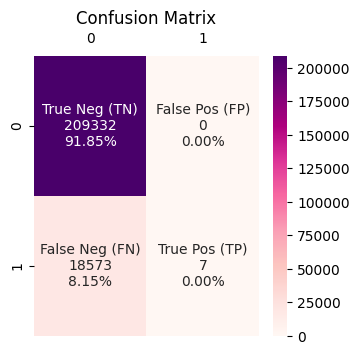

True negative =  209332
False positive =  0
False negative =  18573
True positive =  7


In [28]:
# Initialise une liste vide dfs qui sera utilisée pour stocker les DataFrames
dfs = []

# Initialise des listes vides results et names qui seront utilisées pour stocker
# les résultats de validation croisée et les noms des modèles, respectivement.
results = []
names = []

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'fbeta': make_scorer(fbeta_score, average='weighted', beta=3),
    'Score_Metier': make_scorer(lambda y_test, y_pred: score_metier)  # Utilisez make_scorer pour créer un scorer à partir de la fonction score_gain
    }

# Initialise le modèle 
model = LGBMClassifier(learning_rate=0.03, 
                    max_depth= 3, 
                    n_estimators=200, 
                    num_leaves= 8)

# Démarre un chronomètre pour suivre le temps pris par le modèle.
start_time_model = time.time()

# Définit un objet KFold avec 5 divisions pour la validation croisée.
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

# Effectue la validation croisée en utilisant la fonction cross_validate,
# qui calcule les métriques de performance spécifiées pour le modèle donné,
# les données d'entraînement (X_train et y_train).
cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)

# Ajuste le modèle sur les données d'entraînement (X_train et y_train).
lgbm = model.fit(X_train, y_train)

# Prédit les valeurs cibles pour les données de test (X_test).
y_pred = lgbm.predict(X_test)

# Matrice de confusion 
TN, FP, FN, TP = cf_mat(y_test, y_pred, (8,8))

# Score metier
score_metier = score(TN, FP, FN, TP, 10, -1, -100, 0)

# Add score_gain to DataFrame
cv_results['test_scmetier'] = score_metier


# Ajoute les résultats de la validation croisée, le nom du modèle et le DataFrame
# des résultats aux listes respectives (results, names et dfs)
results.append(cv_results)
names.append('LGBMClassifier')
df = pd.DataFrame(cv_results)
df['model'] = 'LGBMClassifier'
dfs.append(df)

# Concatène tous les DataFrames de la liste dfs en un seul DataFrame final,
# en ignorant l'indice d'origine.
final = pd.concat(dfs, ignore_index=True)


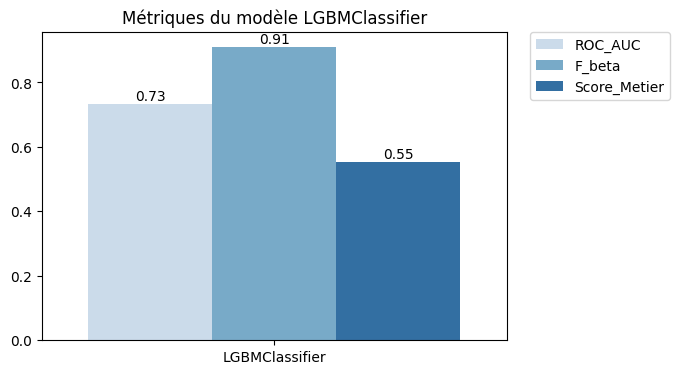

In [29]:
# extraire les colonnes 'model', 'test_roc_auc' et 'test_fbeta' du 
# DataFrame 'final' et les assigne à la variable 'evaluation'.
evaluation = final[['model','test_roc_auc','test_fbeta', 'test_scmetier']]

# regrouper les données de 'evaluation' par la colonne 'model' 
# et calculer la moyenne des autres colonnes pour chaque groupe. 
# Le résultat est assigné à la variable 'eval_ag'.
eval_ag = evaluation.groupby("model").mean()

# assigner les valeurs de l'index de 'eval_ag' à la colonne 'model'. 
# Cela permet d'avoir une colonne 'model' contenant les mêmes valeurs que l'index
eval_ag['model'] = eval_ag.index

#  renommer les colonnes 'test_roc_auc' et 'test_fbeta' de 'eval_ag' en 'ROC_AUC' 
# et 'F_beta' respectivement.
eval_ag.rename(columns={'test_roc_auc': 'ROC_AUC',
                        'test_fbeta':'F_beta',
                        'test_scmetier': 'Score_Metier'}, inplace=True)

# transforme le DataFrame 'eval_ag' en format tabulaire en utilisant la fonction melt(). 
# La colonne 'model' est spécifiée comme variable d'identification.
stack=eval_ag.melt(id_vars=['model'])


# Définir une palette personnalisée avec les couleurs souhaitées
custom_palette = sns.color_palette("Blues", 3)


# Créer une figure et des axes pour le graphique à afficher
fig, axes = plt.subplots(figsize=(6, 4))
plt.title('Métriques du modèle LGBMClassifier', fontsize=12)

# Utiliser la palette personnalisée dans le graphique à barres
ax = sns.barplot(x='model', y='value', hue='variable', data=stack, ax=axes, palette=custom_palette)

# Ajouter les étiquettes de valeur au-dessus des barres
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.01, "%.2f" % p.get_height(), ha="center")

# Rotation des étiquettes sur l'axe x si nécessaire
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

plt.xlabel("")
plt.ylabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.draw()


## 4. ÉVALUATION DU MODÈLE AVEC TRAITEMENT DES CLASSES DÉSÉQUILIBRÉES

In [30]:
print('Ratio du déséquilibre {:.8%}'.format(data_for_modelling.TARGET.value_counts()[1]/data_for_modelling.TARGET.value_counts()[0]))


Ratio du déséquilibre 8.88081206%


### 4.1 SMOTE

In [31]:
model = lgbm
steps = [('smote',SMOTE()), ('model', model)]
pipeline = Pipeline(steps=steps)

kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cv_results = cross_validate(pipeline, X_train, y_train,
                            cv=kfold, scoring=scoring)
model_fit = model.fit(X_train, y_train)
y_pred = model_fit.predict(X_test)

df = pd.DataFrame(cv_results)
df_smote=pd.DataFrame(df.mean(axis=0)).transpose()
df_smote["meth"]="SMOTE"

### 4.2 SMOTE ET RandomUnderSampler

In [32]:
model = lgbm
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.28)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cv_results = cross_validate(pipeline, X_train, y_train,
                            cv=kfold, scoring=scoring)
model_fit = model.fit(X_train, y_train)
y_pred = model_fit.predict(X_test)
df = pd.DataFrame(cv_results)
df_smote_rand=pd.DataFrame(df.mean(axis=0)).transpose()
df_smote_rand['meth']="SMOTE_RandomUnderSampler"

### 4.3 ADASYN

In [33]:

model = lgbm
steps = [('adasyn',ADASYN()), ('model', model)]
pipeline = Pipeline(steps=steps)

kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cv_results = cross_validate(pipeline, X_train, y_train,
                            cv=kfold, scoring=scoring)
model_fit = model.fit(X_train, y_train)
y_pred = model_fit.predict(X_test)
df = pd.DataFrame(cv_results)
df_adasyn=pd.DataFrame(df.mean(axis=0)).transpose()
df_adasyn["meth"]="ADASYN"

### 4.4 Graphique des métrics issus des methodes d'équilibrage des classes

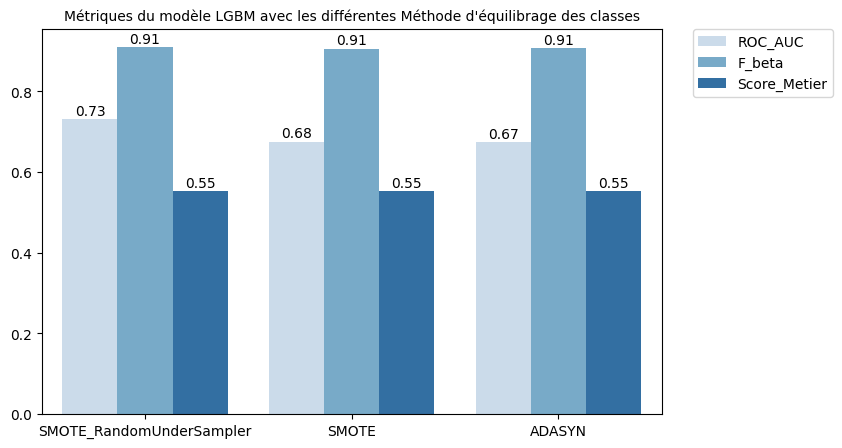

In [34]:
df=pd.concat([df_smote_rand,df_smote,df_adasyn])
df=df[['meth','test_roc_auc','test_fbeta', 'test_Score_Metier']]
df.rename(columns={'test_roc_auc': 'ROC_AUC',
                   'test_fbeta':'F_beta',
                   'test_Score_Metier': 'Score_Metier',
                   'meth':'Méthode'},inplace=True)

stack=df.melt(id_vars=['Méthode'])



fig, axes = plt.subplots(figsize=(8, 5))
plt.title("Métriques du modèle LGBM avec les différentes Méthode d'équilibrage des classes", fontsize=10)

# Définir une palette personnalisée avec les couleurs souhaitées
custom_palette = sns.color_palette("Blues", 3)

# Utiliser la palette personnalisée dans le graphique à barres
ax = sns.barplot(x='Méthode', y='value', hue='variable', data=stack, ax=axes, palette=custom_palette)

# Ajouter les étiquettes de valeur au-dessus des barres
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.01, "%.2f" % p.get_height(), ha="center") 

plt.xlabel("")
plt.ylabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.draw()


## 5. RÉÉVALUTION DU MODÈLE LGBM 

In [55]:
# Charger les descripteurs ORB extraits dans la question précédente
with open('./data/data_for_modelling.pickle', 'rb') as f:
    data_for_modelling = pickle.load(f)

In [56]:
data_for_modelling.shape  

(284891, 358)

In [57]:
#data_for_modelling.rename(columns={'PREV_PRODUCT_COMBINATION_POSindustrywithoutinterest_MEAN': 'PREV_PRODUCT_COMBINATION_POSin_MEAN'}, inplace=True)
#data_for_modelling.rename(columns={'PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN': 'PREV_NAME_SELLER_INDUSTRY_Cons_MEAN'}, inplace=True)


In [58]:
X = data_for_modelling.copy()
y = X['TARGET']
X.drop(columns=['TARGET'],inplace=True)

X_test,X_train,y_test,y_train=train_test_split(X,y,test_size=0.20)

# StandardScaler
# Fit on the training data
scaler = StandardScaler()
X_test=scaler.fit_transform(X_test)
X_train=scaler.fit_transform(X_train)

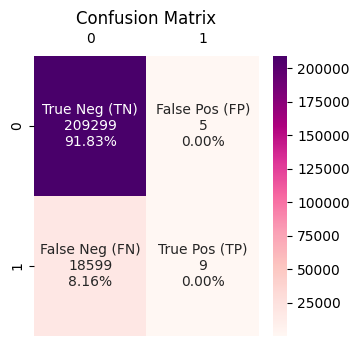

True negative =  209299
False positive =  5
False negative =  18599
True positive =  9


In [59]:
# Initialise une liste vide dfs qui sera utilisée pour stocker les DataFrames
dfs = []

# Initialise des listes vides results et names qui seront utilisées pour stocker
# les résultats de validation croisée et les noms des modèles, respectivement.
results = []
names = []

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'fbeta': make_scorer(fbeta_score, average='weighted', beta=3),
    'Score_Metier': make_scorer(lambda y_test, y_pred: score_metier)  # Utilisez make_scorer pour créer un scorer à partir de la fonction score_gain
    }

# Initialise le modèle 
lgbm = LGBMClassifier(learning_rate=0.03, 
                    max_depth= 3, 
                    n_estimators=200, 
                    num_leaves= 8)

# Démarre un chronomètre pour suivre le temps pris par le modèle.
start_time_model = time.time()

#########################################################
model = lgbm
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.28)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

#######################################################@

# Définit un objet KFold avec 5 divisions pour la validation croisée.
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
# Effectue la validation croisée en utilisant la fonction cross_validate,
# qui calcule les métriques de performance spécifiées pour le modèle donné,
# les données d'entraînement (X_train et y_train).
cv_results = cross_validate(pipeline, X_train, y_train, cv=kfold, scoring=scoring)

# Ajuste le modèle sur les données d'entraînement (X_train et y_train).
model_lgbm = model.fit(X_train, y_train)
# Prédit les valeurs cibles pour les données de test (X_test).
y_pred = model_lgbm.predict(X_test)

# Matrice de confusion 
TN, FP, FN, TP = cf_mat(y_test, y_pred, (8,8))

# Score metier
score_metier = score(TN, FP, FN, TP, 10, -1, -100, 0)

# Add score_gain to DataFrame
cv_results['test_scmetier'] = score_metier


# Ajoute les résultats de la validation croisée, le nom du modèle et le DataFrame
# des résultats aux listes respectives (results, names et dfs)
results.append(cv_results)
names.append('LGBMClassifier')
df = pd.DataFrame(cv_results)
df['model'] = 'LGBMClassifier'
dfs.append(df)

# Concatène tous les DataFrames de la liste dfs en un seul DataFrame final,
# en ignorant l'indice d'origine.
final = pd.concat(dfs, ignore_index=True)


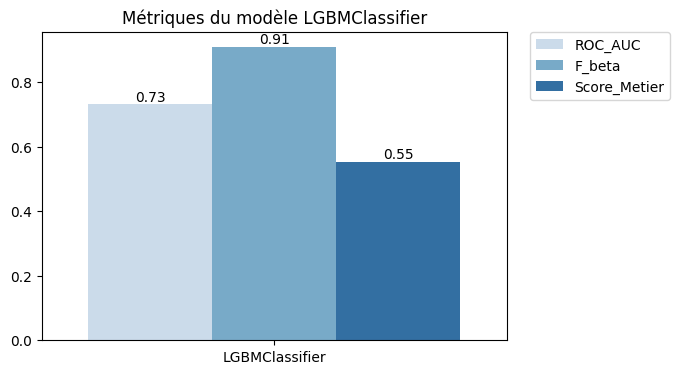

In [60]:
# extraire les colonnes 'model', 'test_roc_auc' et 'test_fbeta' du 
# DataFrame 'final' et les assigne à la variable 'evaluation'.
evaluation = final[['model','test_roc_auc','test_fbeta', 'test_scmetier']]

# regrouper les données de 'evaluation' par la colonne 'model' 
# et calculer la moyenne des autres colonnes pour chaque groupe. 
# Le résultat est assigné à la variable 'eval_ag'.
eval_ag = evaluation.groupby("model").mean()

# assigner les valeurs de l'index de 'eval_ag' à la colonne 'model'. 
# Cela permet d'avoir une colonne 'model' contenant les mêmes valeurs que l'index
eval_ag['model'] = eval_ag.index

#  renommer les colonnes 'test_roc_auc' et 'test_fbeta' de 'eval_ag' en 'ROC_AUC' 
# et 'F_beta' respectivement.
eval_ag.rename(columns={'test_roc_auc': 'ROC_AUC',
                        'test_fbeta':'F_beta',
                        'test_scmetier': 'Score_Metier'}, inplace=True)

# transforme le DataFrame 'eval_ag' en format tabulaire en utilisant la fonction melt(). 
# La colonne 'model' est spécifiée comme variable d'identification.
stack=eval_ag.melt(id_vars=['model'])


# Définir une palette personnalisée avec les couleurs souhaitées
custom_palette = sns.color_palette("Blues", 3)


# Créer une figure et des axes pour le graphique à afficher
fig, axes = plt.subplots(figsize=(6, 4))
plt.title('Métriques du modèle LGBMClassifier', fontsize=12)

# Utiliser la palette personnalisée dans le graphique à barres
ax = sns.barplot(x='model', y='value', hue='variable', data=stack, ax=axes, palette=custom_palette)

# Ajouter les étiquettes de valeur au-dessus des barres
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.01, "%.2f" % p.get_height(), ha="center")

# Rotation des étiquettes sur l'axe x si nécessaire
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

plt.xlabel("")
plt.ylabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.draw()


In [43]:
with open('./data/lgbm_final.pkl', 'wb') as f:
    pickle.dump(model_lgbm, f)

In [61]:
data_for_modelling.head() 

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE_Cashloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,...,PREV_NAME_PAYMENT_TYPE_Cashlessfromtheaccountoftheemployer_MEAN,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_PAYMENT_TYPE_nan_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,PREV_CODE_REJECT_REASON_VERIF_MEAN,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_CODE_REJECT_REASON_nan_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_Other_A_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_CLIENT_TYPE_nan_MEAN,PREV_NAME_GOODS_CATEGORY_AdditionalService_MEAN,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_AudioVid

In [45]:
with open('./data/data_for_modelling_final.pickle', 'wb') as f:
    pickle.dump(data_for_modelling, f)

In [234]:
mlflow.end_run()

In [ ]:
!mlflow ui 

[2023-06-07 17:12:37 +0200] [5933] [INFO] Starting gunicorn 20.1.0
[2023-06-07 17:12:37 +0200] [5933] [INFO] Listening at: http://127.0.0.1:5000 (5933)
[2023-06-07 17:12:37 +0200] [5933] [INFO] Using worker: sync
[2023-06-07 17:12:37 +0200] [5934] [INFO] Booting worker with pid: 5934
[2023-06-07 17:12:37 +0200] [5935] [INFO] Booting worker with pid: 5935
[2023-06-07 17:12:37 +0200] [5936] [INFO] Booting worker with pid: 5936
[2023-06-07 17:12:37 +0200] [5937] [INFO] Booting worker with pid: 5937
